Embracing uncertainty on Total Daily Energy Expenditure calculations
=======================
A couple months ago I decided that it was time to lose some weight. So that's what I did. It's pretty easy when you cut through all the diet hype and bro science and realise that it's mostly just a matter of calories in, calories out. Eat less than you burn and voila, weight loss. 

To control the rate at which the weight is lost, it's wise to set a fixed fixed caloric deficit. Losing too much too quickly can be detrimental to holding on to lean body mass (muscle), and losing it too slowly means being stuck in a deficit for longer than necessary. There's an optimum here. I went with -0.5 kg / week after consulting multiple sources (mainly Martin Berkhan's articles and the Reddit AMA). There's approximately 7700 calories in 1 kg of fat, so -0.5 kg per week means a weekly deficit of 3850 cals. Spread out over 7 days, that's 550 cals per day. (We're technically talking kilocalories here, or kcals, but I'm going to just informally use "cals" here like most people do.) Easy so far. 

Now, this deficit needs to be subtracted from your Total Daily Energy Expenditure, or TDEE. But how do you figure out what your TDEE is? One way to estimate your TDEE, is to first calculate your BMR, Base Metabolic Rate, the amount of energy that you need to just feed your organs and staying alive. There's formulas for this, such as the Harris-Benedict equation, that depend on gender, weight, length and age. Then the BMR gets multiplied by an activity multiplier. The formula suggests 1.2 for "sedentary", 1.375 for "lightly active" or 1.5 for "active". This is how MyFitnessPal sets your goals, and FitBit, and many other apps.

This all is a bit wonky to me. The BMR estimate is exactly that: an estimate, based on a linear regression somebody did many years ago. And the activity multiplier seems like a vague fudge factor to make the equations sort-of work. Also, there's a big gap between 1.2 and 1.375. Maybe it should be 1.3 for some individuals? What would that be called, "very lightly active?" Well, this is why most people who are a bit serious about this, estimate their TDEE based on the two things they *can* observe, namely: weight (change) and cal intake. But the way I've seen this done isn't really satisfying to me either.

Here's why. People tend to assume perfect weight measurements and perfect food tracking. But the weight you observe on a scale isn't necessarily your true weight: it depends on when you had your last bowel movement, the amount of retained fluids, etc. This is a form of *systematic uncertainty*. And the scale isn't perfect either. Step on it twice in a row and you'll see .1 or .2 kg differences. This is a source of *statistical uncertainty*. And tracking food perfectly is impossible, unless you put *every single thing* that goes into your mouth on a (perfect) scale. And even then there's differences between package labels and what's in a package.

My goal here is to estimate the uncertainty on my activity multiplier, which I am renaming to "fudge factor" from hereon out. This gives me an uncertainty on my TDEE estimate. Inputs are a 3-month cal intake log and daily weight measurements. I'll be using the probablistic programming package **PyMC3**.

In [6]:
import glob
from itertools import zip_longest
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [7]:
LENGTH_CM = 185
AGE = 32 
PRIOR_FUDGE = 1.375  # I like to think I qualify for "lightly active"
FITBIT_WEIGHT_EXPORT_PATH = "data/tdee/fitbit/"
MFP_FILE = "data/tdee/mfp/Nutrition-Summary-2018-03-01-to-2018-06-01.csv"
MIN_DATE = '2018-03-17'
MAX_DATE = '2018-05-30'

def bmr(weight):
    # This is the Harris-Benedict equation.
    return 66.5 + (13.75 * weight) + (5.003 * LENGTH_CM) - (6.755 * AGE)

### Load weight from FitBit exports

Loaded weight data from 2018-03-17 to 2018-05-29


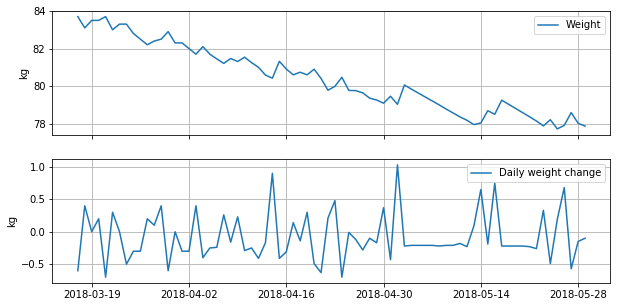

In [10]:
def load_weight():
    """
    Load weight from FitBit data. Fitbit automatically interpolates 
    linearly between days if data is missing, so we don't need to 
    do that ourselves.
    """
    weight_files = glob.glob(
        os.path.join(FITBIT_WEIGHT_EXPORT_PATH, "*.csv"))
    weight = pd.concat((pd.read_csv(f, skiprows=1) for f in weight_files))
    weight.columns = [s.lower() for s in weight.columns]
    weight = weight.drop(['bmi', 'fat'], axis=1) 
    weight['date'] = pd.to_datetime(weight['date'], format='%d-%m-%Y')
    weight = weight.set_index('date').sort_index()
    weight = weight[(weight.index >= MIN_DATE) & 
                    (weight.index <= MAX_DATE)]
        
    # Compute weight changed *during the day*. I weigh myself first thing 
    # in the morning, so the weight for next morning of the next day 
    # *should* represent the weight lost during the previous day:
    weight['weight_chg'] = weight['weight'].shift(-1) - weight['weight']
    # This drops the last record, which has a NaN due to shifting:
    weight = weight.dropna()  
    
    print("Loaded weight data from {} to {}"
          .format(weight.index.min().date(), weight.index.max().date()))
    return weight

weight = load_weight()
_, (upper, lower) = plt.subplots(ncols=1, nrows=2, figsize=(10, 5), 
                                 sharex=True)
upper.plot(weight.index, weight.weight, label='Weight')
upper.legend()
upper.set_ylabel('kg')
upper.grid()
lower.plot(weight.index, weight.weight_chg, label='Daily weight change')
lower.legend()
lower.set_ylabel('kg')
lower.grid()
plt.show()

### Load cal intake from MyFitnessPal exports

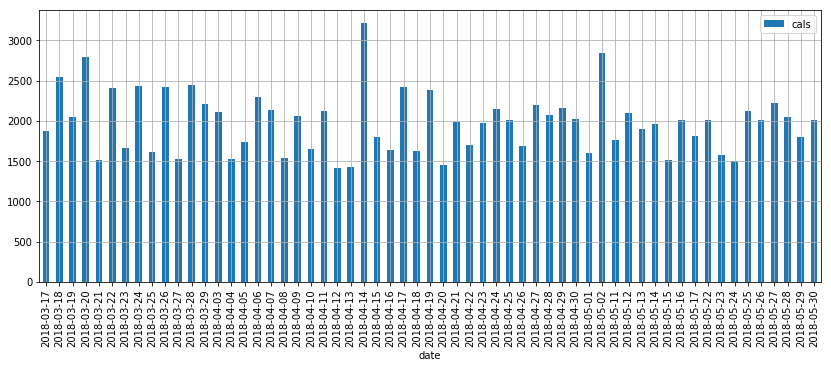

In [13]:
def load_mfp_daily():
    mfp = pd.read_csv(MFP_FILE)
    mfp.columns = [s.lower() for s in mfp.columns]
    mfp = (mfp
            .rename(columns={'calories': 'cals', 'fat (g)': 'fat', 
                             'carbohydrates (g)': 'carb', 
                             'protein (g)': 'protein'})
            .set_index('date')
            [['meal', 'cals', 'fat', 'carb', 'protein']]
            .sort_index()
    )
    #mfp.index = pd.to_datetime(mfp.index)
    mfp = mfp[(mfp.index >= MIN_DATE) & (mfp.index <= MAX_DATE)]
    mfp_daily = mfp.groupby(level=0).sum()
    return mfp_daily

mfp_daily = load_mfp_daily()
mfp_daily.plot(y='cals', figsize=(14, 5), grid=True, kind='bar', color='C0');

The first thing that jumps out here is the big difference between subsequent days. This might seem like poor diet adherence, but actually it's pretty good. Instead of using the same deficit every day, I've actually been cycling calories between workout and rest days, eating more on workout days than on rest days. Ok, I admit, 2018-04-14 and 2018-05-02 were pretty bad. 

The workouts themselves weren't very intense (lifting weights) so for simplicity purposes I'm ignoring calory burn through exercise (it's no more than 100 cals per workout day).

If you look more closely, you'll note that there are 3 short periods with no data (March 31-Apr 3, 3-10 May and 18-21 May).

In [14]:
df = (mfp_daily[['cals']]
    .merge(weight, 
           left_index=True, right_index=True, how='inner')
    .assign(bmr=lambda r: bmr(r['weight']))
)
pd.concat((df.head(3), df.tail(3)))

,cals,weight,weight_chg,bmr
date,,,,
2018-03-17,1878.8,83.70,-0.60,1926.7700
2018-03-18,2537.7,83.10,0.40,1918.5200
2018-03-19,2051.5,83.50,0.00,1924.0200
2018-05-27,2224.9,78.59,-0.57,1856.5075
2018-05-28,2044.3,78.02,-0.15,1848.6700
2018-05-29,1803.9,77.87,-0.10,1846.6075


/Users/jvlier/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/jvlier/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


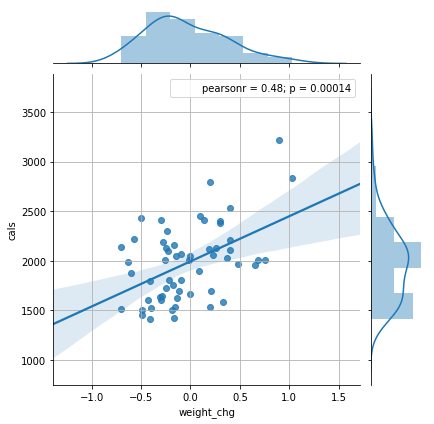

In [26]:
sns.jointplot(df['weight_chg'], df['cals'], kind='reg')
plt.grid()

Although noisy, there seems to be some sort of relationship between daily cal intake and daily weight change.

# The naive approach

Right, so before we dive into Bayesian stats, let's try it the old fashioned way.

Since there's 7700 calories in a kg of fat, a given amount of weight loss equates to a certain amount of calories burned:

$\text{cals_burned} = \text{weight_change [kg]} \times 7700$

And then the TDEE must have been:

$\text{tdee} = \text{cals_in} - \text{cals_burned}$

If you remember that the fudge factor gets multiplied by the BMR to calculate TDEE, you can see that we can recover the fudge factor by:

$\displaystyle \text{fudge_factor} = \frac{\text{tdee}}{\text{bmr}}$

Let's apply this not just to daily differences, but to multiple ranges of (consecutive) days. There is bound to be alot of noise in the day-to-day data.

Filtered to all  1-day consecutive period(s) (58 periods). Naive fudge mean: 1.20, median: 1.46
Filtered to all  2-day consecutive period(s) (54 periods). Naive fudge mean: 1.22, median: 1.25
Filtered to all  3-day consecutive period(s) (50 periods). Naive fudge mean: 1.25, median: 1.39
Filtered to all  4-day consecutive period(s) (46 periods). Naive fudge mean: 1.26, median: 1.30
Filtered to all  5-day consecutive period(s) (42 periods). Naive fudge mean: 1.31, median: 1.33
Filtered to all  6-day consecutive period(s) (38 periods). Naive fudge mean: 1.35, median: 1.38
Filtered to all  7-day consecutive period(s) (34 periods). Naive fudge mean: 1.38, median: 1.38
Filtered to all  8-day consecutive period(s) (30 periods). Naive fudge mean: 1.42, median: 1.43
Filtered to all  9-day consecutive period(s) (27 periods). Naive fudge mean: 1.43, median: 1.43
Filtered to all 10-day consecutive period(s) (25 periods). Naive fudge mean: 1.41, median: 1.38
Filtered to all 11-day consecutive perio

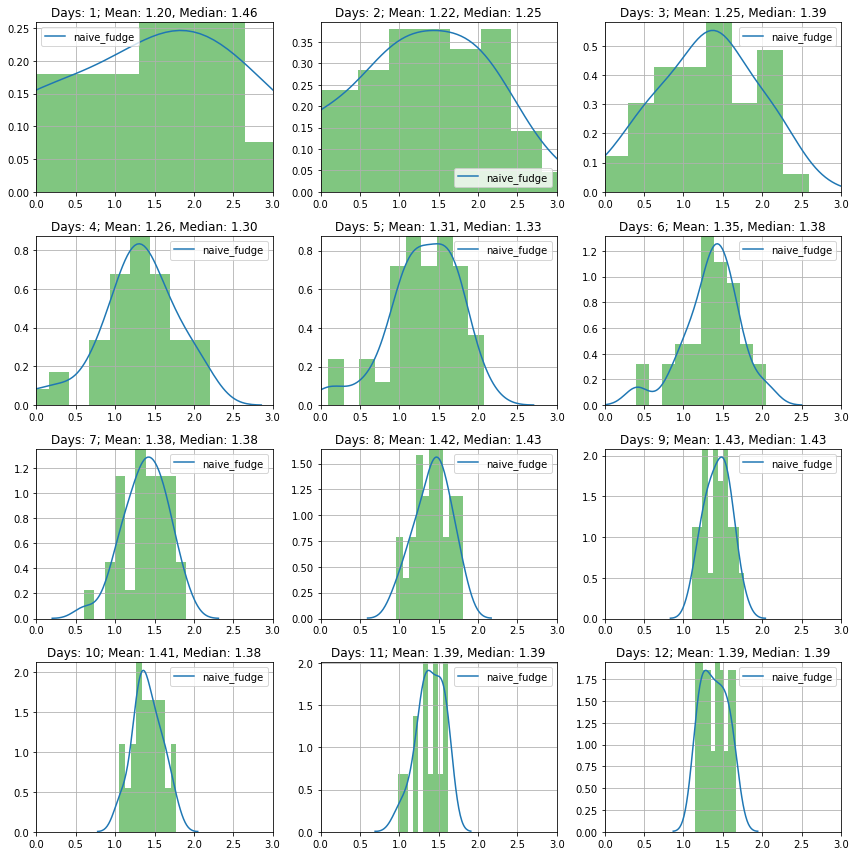

In [25]:
def fudge_multiple_days(df, days):
    df_w = (df
        .assign(prior_tdee=lambda r: r['bmr'] * PRIOR_FUDGE)
        .drop('weight', axis=1)
        .rolling(window=str(days) + 'd', min_periods=days)
        .sum()
        .dropna()
    )
             
    df_w['naive_tdee'] = df_w['cals'] - df_w['weight_chg'] * 7700
    df_w['naive_fudge'] = df_w['naive_tdee'] / df_w['bmr']
    return df_w


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

dfs_windowed = {}
window_sizes = list(range(1, 22))

for days, ax in zip_longest(window_sizes, axes.ravel()):
    df_w = fudge_multiple_days(df, days)
    
    mean = df_w['naive_fudge'].mean()
    median = df_w['naive_fudge'].median()
    print("Filtered to all {:2d}-day consecutive period(s) "
          "({:2d} periods). "
          "Naive fudge mean: {:4.2f}, median: {:4.2f}"
          .format(days, len(df_w), mean, median))

    if ax:
        sns.kdeplot(df_w['naive_fudge'], ax=ax)
        ax.hist(df_w['naive_fudge'], bins=10, density=True, 
                color='C2', alpha=.6)
        ax.set_xlim(0, 3)
        ax.set_title(f"Days: {days}; Mean: {mean:.2f}, "
                     f"Median: {median:.2f}")
        ax.grid()

    dfs_windowed[days] = df_w
    
plt.tight_layout()

Ok... with daily data we get a huge spread in the histogram, and a big difference between the mean and median, but as we increase the range the histogram gets narrower and the summary statistics seem to want to converge. 

What is a good number of days to pick for the naive TDEE estimate?

Intuitively it makes sense to pick a somewhat long period to smooth out the short-term irregularities. But not too long, because we're losing more and more data as the period gets larger. From 9 days onward, virtually all data from May is dropped because of the gaps in the data.

Most online TDEE calculators default to a period of 1 week, but maybe that's not optimal. But what is?

One way to pick a sensible period, is to figure out how long it takes for the weight loss to materialize. 
We can do that by computing the correlation between an accumulating calory deficit and an accumulating weight change over periods with multiple sizes. Then, we simply choose the period size with the highest correlation. We're using the previously computed TDEE to get an estimate for the deficit here.

In [19]:
rs = []
ps = []

for days, df_w in dfs_windowed.items():
    n = len(df_w)
    r, p = pearsonr(df_w['weight_chg'], 
                    df_w['cals'] - df_w['prior_tdee'])
    rs.append(r)
    ps.append(p)

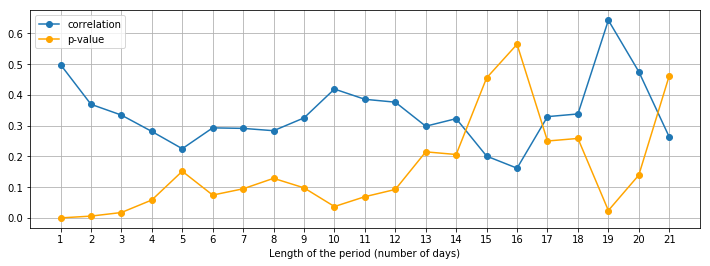

In [22]:
plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.plot(window_sizes, rs, label='correlation', marker='o')
ax.plot(window_sizes, ps, color='orange', label='p-value', marker='o')
ax.set_xticks(window_sizes)
ax.legend(loc='upper left')
ax.set_xlabel("Length of the period (number of days)")
ax.grid()

The correlation is pretty high for daily data, and the p-value is low. The correlation is even higher for periods of 19 days, but I can't say I trust that result given the erratic nature of the p-value line when we exceed 12 days.

Simply going with daily data seems appropriate, However, as we've seen, the fudge factor histogram for daily data doesn't really allow for a reliable estimate.

There is an interesting peak in the correlation plot at 10 days with a relatively low p-value (0.04), so let's use that. This yields a mean of 1.41 and a median of 1.38 for the fudge factor. That sounds reasonable to me. But let's see if we can do this in a nicer way using Bayesian methods. I'm hoping for a good result with the noisy 1-day data, alleviating the need for these period groupings.

# Fire up PyMC

The approach I'm taking here is very simple: I'm creating a linear model to predict cal intake, in which the fudge factor is one of the coefficients. This coeffient is multiplied by the BMR of each day. The other coeffient is the amount of calories in 1 KG of fat, which I'll keep fixed on 7700 as per the literature. This is multiplied by the weight change. There's no intercept (I tried adding one but it stays close to 0 so there's no point).

So:

$\text{cals_in} = \text{weight_change} \times 7700 + \text{fudge_factor} \times \text{BMR}$

For example, to lose 0.1 kg in a day with a BMR of 1800 and a fudge factor of 1.375, you'll have to eat:

$-0.1 \times 7700 + 1.375 \times  1800 = 1705$

I'm assuming that the fudge factor is normally distributed, and the amount of calories as well. The standard deviation for calories is tied to the intake: the more I've logged, the higher the uncertainty likely is. The standard deviation = 30% of total for each observation. I think that's a reasonable assumption.

## Model with daily data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fudge]
100%|██████████| 10500/10500 [00:03<00:00, 2768.37it/s]


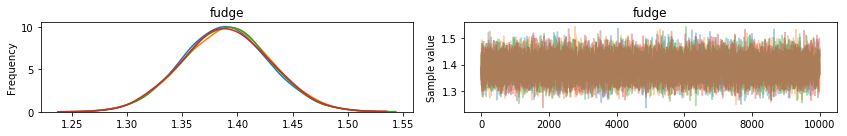

In [96]:
daily_model = pm.Model()

with daily_model:
    # Priors for unknown model parameters
    fudge = pm.Normal('fudge', mu=PRIOR_FUDGE, sd=0.3)

    # Expected value of cal intake, based on observed weight change
    cals_in = df['weight_chg'].values * 7700 + fudge * df['bmr']
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Normal('obs', mu=cals_in, sd=df['cals'] * .3, 
                    observed=df['cals'])
    
    trace = pm.sample(10000)
    
pm.traceplot(trace);

Now we can query this posterior to find its mean and a 95% Credible Interval:

In [90]:
print("Fudge mean: {:3.2f}. 95% CI: [{:3.2f}, {:3.2f}]"
      .format(np.mean(trace['fudge']), 
              np.percentile(trace['fudge'], 5), 
              np.percentile(trace['fudge'], 95)))

Fudge mean: 1.39. 95% CI: [1.32, 1.45]


Pretty neat, right? The value we get here now is pretty close to the naive values that we computed earlier for the 10-day period, except we've computed it in a very simple way on the noisy daily data.

We can also apply the fudge factor posterior to the BMR and find a plausible range for my TDEE:

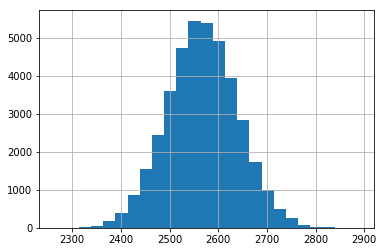

In [91]:
plt.hist(bmr(78) * trace['fudge'], bins=25)
plt.grid()
plt.show()

## Model with 10-day data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fudge]
100%|██████████| 10500/10500 [00:03<00:00, 2885.18it/s]


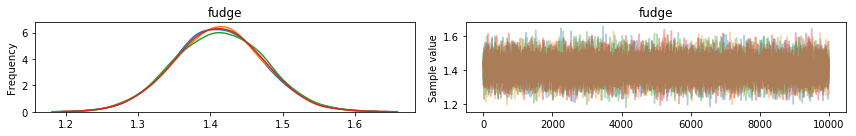

In [92]:
df_w = dfs_windowed[10]

model_10d = pm.Model()

with model_10d:
    fudge = pm.Normal('fudge', mu=PRIOR_FUDGE, sd=0.3)
    cals_in = df_w['weight_chg'].values * 7700 + fudge * df_w['bmr']
    obs = pm.Normal('obs', mu=cals_in, sd=df_w['cals'] * 0.3, 
                    observed=df_w['cals'])
    
    trace = pm.sample(10000)
pm.traceplot(trace);

In [93]:
print("Fudge mean: {:3.2f}. 95% CI: [{:3.2f}, {:3.2f}]"
      .format(np.mean(trace['fudge']), 
              np.percentile(trace['fudge'], 5), 
              np.percentile(trace['fudge'], 95)))

Fudge mean: 1.41. 95% CI: [1.31, 1.51]


The mean is a little higher here, but still very close to the previous result and it actually agrees with the naive result. Also, there is more uncertainty in the posterior distribution. This is very likely because there's less days available in this 10-day dataset, and so there's less evidence available to refine the posterior:

In [94]:
len(df_w), len(df)

(25, 58)

Based on these results, I see no reason to go through the trouble of grouping the data to longer periods. The result with the daily data seems very reasonable.

# Conclusion

I've shown that we can use noisy daily weight loss & calory intake data to estimate a fudge factor (activity multiplier) and TDEE. The daily data can be pretty much directly inserted into the MCMC sampling procedure without much preprocessing. And the output is not just a point estimate, but an entire range of possiblities.

How might you use such a result, you say?

An interesting use case that I'll be trying out soon is moving from a calory deficit to a surplus to gain a bit of muscle. But I want do to this safely, i.e. I don't want to gain too much fat in the process. So I suppose I'll set my cal intake target with a fudge factor of 1.32 rather than 1.45. This is a difference of 1200 calories per week for my BMR, which might not seem like a lot, but over the course of 5 months equates to 1 kg of unnecessary fat gain.

So, wish me luck :-)